In [141]:
import pandas as pd
import matplotlib.pyplot as plt

In [142]:
path_to_file = 'C:/Users/Andrew/Downloads/file_1.txt'
df = pd.read_csv(path_to_file, delimiter = '\t')
len(df)

701827

In [143]:
# Здесь я примерно оценил есть ли смысл анализировать какие то отдельные таски, так как их делали несколько асессеров, 
# но % уникальных тасок слишком велик, поэтому я решил не отталкиваться от этого
uniqueRows = pd.unique(df['tid'])
len(uniqueRows)

635044

In [144]:
# перевел столбцы в datetime
df['assigned_ts'] = pd.to_datetime(df['assigned_ts'])
df['closed_ts'] = pd.to_datetime(df['closed_ts'])

In [145]:
# перевел в более удобный формат в виде разницей во времени между принятием таски и сдачей
df['timeDelta'] = df['closed_ts'] - df['assigned_ts']

In [146]:
# вычислил время на выполение одной микротаски в рамках большой таски
df['timeDelta/microtasks'] = df['timeDelta']//df['Microtasks']

In [147]:
# перевел это все в секунды для удобства
df['microtaskMeanTime'] = df['timeDelta/microtasks'].dt.seconds
df

,login,tid,Microtasks,assigned_ts,closed_ts,timeDelta,timeDelta/microtasks,microtaskMeanTime
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01,0 days 01:03:22,0 days 00:15:50.500000,950
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29,0 days 00:17:59,0 days 00:17:59,1079
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10,0 days 01:08:39,0 days 00:17:09.750000,1029
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56,0 days 00:45:26,0 days 00:45:26,2726
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50,0 days 00:46:08,0 days 00:23:04,1384
...,...,...,...,...,...,...,...,...
701822,login766,195656026.0,1.0,2017-05-15 15:53:27,2017-05-15 16:16:56,0 days 00:23:29,0 days 00:23:29,1409
701823,login766,195656174.0,1.0,2017-05-15 15:53:33,2017-05-15 16:21:53,0 days 00:28:20,0 days 00:28:20,1700
701824,login766,195656466.0,1.0,2017-05-15 15:53:38,2017-05-15 16:23:41,0 days 00:30:03,0 days 00:30:03,1803
701825,login766,195656336.0,3.0,2017-05-15 15:54:18,2017-05-15 16:32:11,0 days 00:37:53,0 days 00:12:37.666666666,757


___

Далее колонка "microtaskMeanTime" будет нашим основным критерием с которым мы будем работать
___
Она отображает среднее время в секундах для выполнения микротаска в текущем таске

In [127]:
# проверил корректность данных
df.isna().any()

login                   False
tid                     False
Microtasks              False
assigned_ts             False
closed_ts               False
timeDelta               False
timeDelta/microtasks    False
microtaskMeanTime       False
dtype: bool

In [128]:
df.where(df.microtaskMeanTime < 0).dropna()

,login,tid,Microtasks,assigned_ts,closed_ts,timeDelta,timeDelta/microtasks,microtaskMeanTime


In [129]:
# Далее для фильтрации выбросов в данных буду использовать IQR подход( https://pythobyte.com/detection-removal-outliers-in-python-adaa857e/ ) 
def subset_by_iqr(df, column, whisker_width=1.5):
    """Remove outliers from a dataframe by column, including optional 
       whiskers, removing rows for which the column value are 
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (':obj:pd.DataFrame'): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of 'whisker_width' * IQR.
    Returns:
        (':obj:pd.DataFrame'): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]

# Первый вариант решения: 
    Каждая строка это разный пользователь и я не буду никак цепляться за колонку "логин"

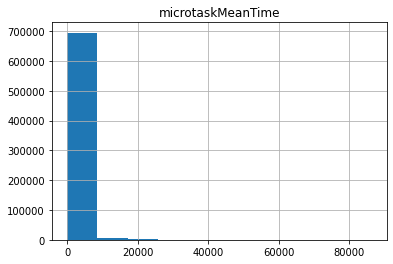

In [130]:
df.hist(column='microtaskMeanTime');

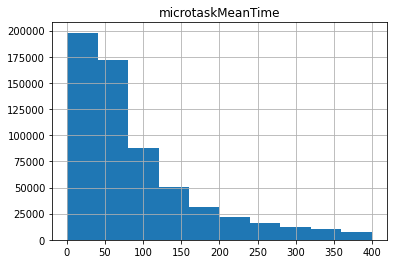

In [131]:
# чищу данные от выбросов
df_IQR = subset_by_iqr(df, 'microtaskMeanTime', whisker_width=1.5)
df_IQR.hist(column='microtaskMeanTime');

In [132]:
# нахожу медиану времени исполнения микротаски
# хоть я и почистил данные от выбросов, но все равно лучше воспользоваться медианой вместо среднего значения
print(df_IQR['microtaskMeanTime'].median())

62.0


# Получается в среднем на выполнение микротаски уходит 62 секунды => оплата ~2N рублей

___
___
___

# Второй вариант решения: 
    В этом случае мы уже анализируем асессеров которые делают эти таски. Во всю используя колонку login 

In [133]:
# получаем массив всех уникальных логинов
uniqueLogins = pd.unique(df['login'])

In [148]:
# вычисляем для каждого асессора его медиану времени выполнения микротаски
medianTimeForUsers = []
for login in uniqueLogins:
    df_by_login = df.where(df.login == login).dropna()
    df_by_login_iqr = subset_by_iqr(df_by_login, 'microtaskMeanTime', whisker_width=1.5)
    medianTimeForUsers.append( df_by_login_iqr['microtaskMeanTime'].median() )

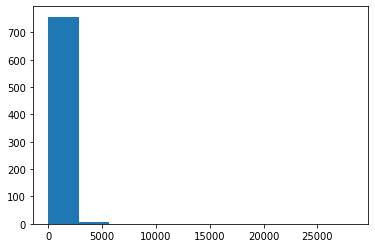

In [149]:
plt.hist(medianTimeForUsers)
plt.show()

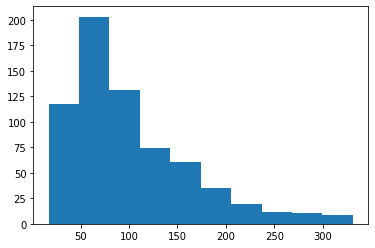

In [151]:
# выше на графике видим что есть асессоры которые делают слишком долго абсолютно все свои таски, следовательно мы считаем их выбросом и фильтруем
df_with_medianTimeForUsers = pd.DataFrame(medianTimeForUsers)
df_iqr_with_medianTimeForUsers = subset_by_iqr(df_with_medianTimeForUsers, 0, whisker_width=1.5)
plt.hist(df_iqr_with_medianTimeForUsers)
plt.show()


In [152]:
df_iqr_with_medianTimeForUsers[0].median()

82.0

# В среднем на выполнение микротаски уходит 82 секунды => оплата ~2.7*N рублей

Ну и самое главное, так какой же результат выбрать, 62 или 82 секунды.

    Проведем эксперимент, допустим у нас есть 5 асессеров которые делают микротаску за [1, 6, 7, 7, 8] секунд соответственно. 
    Как лицо которое должно оплачивать работу, я бы скорее всего подумал что первый ассесор который сделал микротаску за 1 секунду мухлюет, и чтобы подстраховать свой кошелек 
    считал бы их среднее время выполнения микротаски примерно так (1 + (6+7+7+8)/4)/2 = 4 , то есть влияние первого асессора было бы очень сильным на итоговую оценку времени выполнения таски.

    А теперь представим что я получил информацию о том что это все один асессор и он сделал 5 тасок. Тогда я бы подумал что 1 сек это скорее всего выброс в данных(например он выбирал на картинках где дипфейк, а где обычное фото и ему попалось фото своей мамы и он за 1 секунду принял решения что это не дипфейк:) ) и считал бы так: (6+7+7+8)/4 = 7, ну или в крайнем случае (1+6+7+7+8)/5 = 5.8
    
___
    
    Делая вывод из этого "эксперимента" приходим к выводу что более честная итоговая плата за микротаску это 82 секунды => оплата ~2.7*N рублей